# Seminar 6 - MDCT with N = 128

In [1]:
import numpy as np
import sound
import scipy.signal as sig
import scipy.optimize as opt
import scipy.io.wavfile as wav
import pyaudio
import matplotlib.pyplot as plt
import copy
import pickle
plt.rcParams['figure.figsize'] = [8,6]

Load audio file

In [2]:
pathToAudio = "data/Track48.wav"
fs, data = wav.read(pathToAudio)
duration = 5 # seconds
audio = np.array(data[:fs*duration,0]) # use only one channel
print('Sampling rate: {}'.format(fs))
print('Data Type: ', audio.dtype)
print('Shape of one channel: {}'.format(audio.shape))

Sampling rate: 44100
Data Type:  int16
Shape of one channel: (220500,)


#### Definition of neccessary functions


In [7]:
def generate_dct_matrix(N):
    n = np.arange(0, N)
    k = np.arange(0, N)
    T = np.zeros((N, N))
    
    for nn in n:
        for kk in k:
            T[nn][kk] = np.sqrt(2.0/N) * np.cos( (np.pi/N) * (nn+0.5) * (kk+0.5))
            
    return T

def Famatrix(h):
    """produces a diamond shaped folding matrix F from the coefficients f
    (h is a row matrix)
    """
    
    N = int(len(h)/2);
    N_2 = int(N/2)
 
    #fliplr:
    h=h[::-1]  
    Fa=np.zeros((N,N,1))
    Fa[0:N_2,0:N_2,0]=-np.fliplr(np.diag(h[0:N_2]))
    Fa[N_2:N,0:N_2,0]=-np.diag(h[N_2:N])
    Fa[0:N_2,N_2:N,0]=-np.diag(h[N:(N+N_2)]) 
    Fa[N_2:N,N_2:N,0]=np.fliplr(np.diag(h[(N+N_2):2*N]))
    
    return Fa

def sinWindow(N):
    n = np.arange(0,N)
    if (N%2 == 0): # even
        s = np.sin(np.pi/N*(n+0.5))
    else:
        s = np.sin(np.pi/(N+1)*(n+1))
    return s

def raisedCosWinow(N):
    n = np.arange(0,N)
    if (N%2 == 0): # even
        c = 0.5-0.5*np.cos(2*np.pi/N*(n+0.5))
    else: # odd
        c = 0.5-0.5*np.cos(2*np.pi/(N+1)*(n+1))    
    return c

def polmatmult(A,B):
    """polmatmult(A,B)
    multiplies two polynomial matrices (arrays) A and B, where each matrix entry is a polynomial.
    Those polynomial entries are in the 3rd dimension
    The thirs dimension can also be interpreted as containing the (2D) coefficient
    exponent of z^-1.
    Result is C=A*B;"""
   
    [NAx, NAy, NAz] = np.shape(A);
    [NBx, NBy, NBz] = np.shape(B);

    "Degree +1 of resulting polynomial, with NAz-1 and NBz-1 being the degree of the..."
    Deg = NAz + NBz -1;
    #initialize (with complex zeros):
    C = np.zeros((NAx,NBy,Deg))#*(1+1j);
    "Convolution of matrices:"
    for n in range(0,(Deg)):
        for m in range(0,n+1):
            if ((n-m)<NAz and m<NBz):
               C[:,:,n] = C[:,:,n]+ np.dot(A[:,:,(n-m)],B[:,:,m]);



    return C

def x2polyphase(x,N):
    """Converts input signal x (a row vector) into a polyphase row vector 
    for blocks of length N"""      

    #Number of blocks in the signal:
    L = int(np.floor(max(np.shape(x))/N))  
    #print("L= ", L)

    xp = np.zeros((1,N,L))
    for m in range(0,L):
        xp[0,:,m] = x[m*N+np.arange(N)]
    return xp

def polyphase2x(xp):
    """Converts polyphase input signal xp (a row vector) into a contiguos row vector
    For block length N, for 3D polyphase representation (exponents of z in the third 
    matrix/tensor dimension)"""
    #Number of blocks in the signal
    [r,N,L] = np.shape(xp);
    x = np.zeros((1,N*L));
    for m in range(L):
        x[0,m*N+np.arange(N)]=xp[0,:,m]
    return x

#### Implementation of filter

In [10]:
nSubbands = 128

#Sine Window
h = raisedCosWinow(2*nSubbands)

#Folding Matrix:
Fa=Famatrix(h)

#Delay Matrix D(z):
N_2 = int(nSubbands/2)
Dp = np.zeros((nSubbands,nSubbands,2))
Dp[:,:,0] = np.diag(np.hstack((np.zeros(N_2), np.ones(N_2)))) #z^0
Dp[:,:,1] = np.diag(np.hstack((np.ones(N_2), np.zeros(N_2)))) #z^-1

T = generate_dct_matrix(nSubbands)
Faz=polmatmult(Fa,Dp)
T_tensor = np.zeros((nSubbands, nSubbands, 1))
T_tensor[:, :, 0] = T


# H is tensor: H[:,:,0] has the impulse response samples from 0 to nSubbands-1, H[:,:,1] has the impulse response samples
# from nSubbands to nSubbands*2-1 ==> in total the IRs have length 2*nSubbands
H_MDCT = polmatmult(Faz, T_tensor)

# print('Dp:', Dp)
# print('Faz:', Faz)

#### Plot of the filters

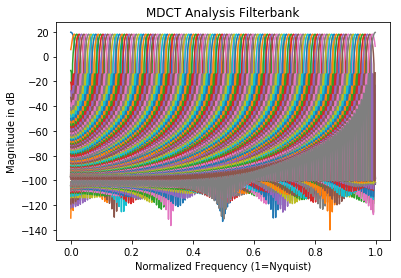

In [11]:
# extract IRs from H for plotting
IR_MDCT = np.vstack((H_MDCT[:,:,1], H_MDCT[:,:,0]))

# build up MDCT filterbank
fb_MDCT = [np.flipud(IR_MDCT[:, column]) for column in np.arange(0,nSubbands)]

for h in fb_MDCT:
    W,H = sig.freqz(h)
    plt.plot(W/(np.pi),20*np.log10(np.abs(H+10e-6)))
    plt.title('MDCT Analysis Filterbank')
    plt.xlabel('Normalized Frequency (1=Nyquist)')
    plt.ylabel('Magnitude in dB')

Filter Audio with MDCT Filterbank

In [12]:
zeropad_audio = np.zeros(int(np.ceil(len(audio)/nSubbands) * nSubbands))
zeropad_audio[:len(audio)] = audio

# apply filter in z-domain
xp = x2polyphase(zeropad_audio,nSubbands)
yp=polmatmult(xp,H_MDCT)

Synthesis with MDCT

In [13]:
# Invert analysis folding matrix to get synthesis folding matrix
Fs=np.zeros(Fa.shape)
Fs[:,:,0]=np.linalg.inv(Fa[:,:,0])

#Inverse Delay Matrix with delay:
Dpi=np.zeros((nSubbands,nSubbands,2))
Dpi[:,:,1]=np.diag(np.hstack((np.zeros(N_2),np.ones(N_2))))
Dpi[:,:,0]=np.diag(np.hstack((np.ones(N_2),np.zeros(N_2))))

G_MDCT = polmatmult(polmatmult(T_tensor, Dpi), Fs)

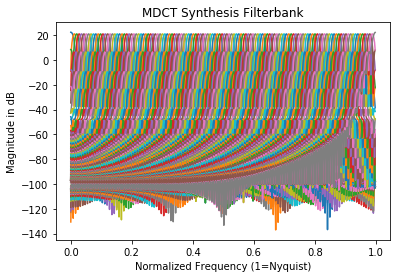

In [14]:
# extract IRs from G for plotting
IR_iMDCT = np.hstack((G_MDCT[:,:,0], G_MDCT[:,:,1]))

fb_iMDCT = []
# build up MDCT filterbank
[fb_iMDCT.append(IR_iMDCT[row, :]) for row in np.arange(0,nSubbands)]

for h in fb_iMDCT:
    W,H = sig.freqz(h)
    plt.plot(W/(np.pi),20*np.log10(np.abs(H+10e-6)))
    plt.title('MDCT Synthesis Filterbank')
    plt.xlabel('Normalized Frequency (1=Nyquist)')
    plt.ylabel('Magnitude in dB')

In [18]:
#Multiply with synthesis matrix G:
xrekp=polmatmult(yp,G_MDCT)
xrek=polyphase2x(xrekp)

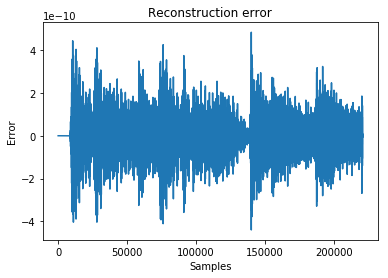

In [20]:
recon_mdct = xrek[0]

plt.plot(recon_mdct[nSubbands:-nSubbands] - zeropad_audio)
plt.title('Reconstruction error')
plt.xlabel('Samples')
plt.ylabel('Error')
plt.show()


In [21]:
sound.sound(recon_mdct, fs)

* done
